In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils.validation import check_X_y, check_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from tensorflow import keras
from keras.layers import Input, Dense, Dropout

In [2]:
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.transformers import NeuralRegressionTransformer
from proglearn.voters import NeuralRegressionVoter
from proglearn.deciders import KNNRegressionDecider, NeuralRegressionDecider

This notebook test the progressive learning regression methodology on a few toy multitasks with known outcomes, to see if it can successfully learn and share representations. In all cases, three tasks are presented. Each are regression of a single real-valued response on a real-valued, $d$ dimensional vector. In all cases, the vector will be scaled, have some known transformation applied to it (common for all tasks), and then another vote-decision function that maps it to the output (which differs for each task). The following three multitask then differ on the following five parameters: how the input is sampled, which common transformer, and which vote-decision to use for each of the three subtasks.

In [3]:
# n is the per-task sample size.
def generate_data(n, d, transform, vote, sigma = 1):
    X = np.random.randn(n, d)
    y = vote(transform(X)) + np.random.normal(loc=0.0, scale=sigma, size=n)
    
    return X, y

def plot_data(data):
    sns.set(font_scale = 1.5)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    fig, ax = plt.subplots(1, 1, figsize = (5,4))
    
    colors = ["#c51b7d", "#2166ac", "#d95f02"]
    
    for (X, y), color in zip(data, colors):
        if X.shape[1] != 1:
            raise ValueError("X must be one-dimensional to plot.")
        
        ax.scatter(X, y, color = color, marker = ".")    
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = check_array(y_true, ensure_2d=False), check_array(y_pred, ensure_2d=False)
    return np.mean(np.abs((y_true - y_pred) / y_true))

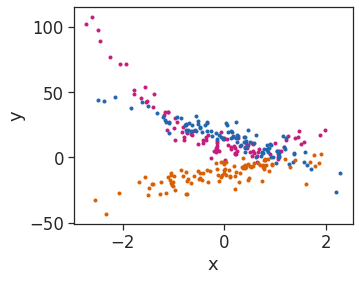

In [4]:
n = 100
d = 1

rep_dim = 29
W = np.random.randn(rep_dim, d)
b = np.random.randn(rep_dim)
v1 = np.random.randn(rep_dim)
v2 = np.random.randn(rep_dim)
v3 = np.random.randn(rep_dim)
vs = [v1, v2, v3]

data = []
for v in vs:
    data.append(generate_data(n, d, lambda X: np.square(np.dot(X, W.T) + b), lambda X: np.dot(X, v), sigma = 5))

plot_data(data)

In [5]:
# Generate a PL that has a neural transformer, a neural voter (with one output unit), and a KNN decider.
def build_predictive_ensembler(d, verbose_transform = False, verbose_vote = False):    
    
    default_transformer_class = NeuralRegressionTransformer
        
    # Representation
    network = keras.Sequential()
    network.add(Input(shape=(d,), name = 'input'))
    network.add(Dense(16, activation='relu', name = 'fc0'))
    network.add(Dense(4, activation='relu', name = 'fc1')) 
    
    # Output layer.
    network.add(Dense(1, activation = 'linear', name = 'output'))

    default_transformer_kwargs = {"network" : network, 
                                  "euclidean_layer_idx" : -2,
                                  "loss" : "mae",
                                  "optimizer" : keras.optimizers.Adam(3e-2),
                                  "fit_kwargs" : {"epochs" : 100, "verbose" : verbose_transform}
                                 }

    default_voter_class = NeuralRegressionVoter
    default_voter_kwargs = {"loss" : "mae",
                            "verbose" : verbose_vote,
                            "epochs" : 100,
                            "lr" : 3e-2
                           }
    default_decider_class = KNNRegressionDecider
    
    return ProgressiveLearner(default_transformer_class = default_transformer_class, 
                              default_transformer_kwargs = default_transformer_kwargs,
                              default_voter_class = default_voter_class,
                              default_voter_kwargs = default_voter_kwargs, 
                              default_decider_class = default_decider_class,
                              default_decider_kwargs = {})

In [10]:
# Generate a PL that has a neural transformer, a neural voter (with one output unit), and a KNN decider.
def build_representation_ensembler(d, num_tasks = 3, verbose_transform = False, verbose_decide = False):    
    
    default_transformer_class = NeuralRegressionTransformer
    
    backbone_layer_size = 4 # second to last layer in each transformer and the full decider.
        
    # Representation
    transform_network = keras.Sequential()
    transform_network.add(Input(shape=(d,), name = 'input'))
    transform_network.add(Dense(16, activation='relu', name = 'fc0'))
    transform_network.add(Dense(backbone_layer_size, activation='relu', name = 'fc1')) 
    
    # Output layer.
    transform_network.add(Dense(1, activation = 'linear', name = 'output2'))

    default_transformer_kwargs = {"network" : transform_network, 
                                  "euclidean_layer_idx" : -2,
                                  "loss" : "mae",
                                  "optimizer" : keras.optimizers.Adam(3e-2),
                                  "fit_kwargs" : {"epochs" : 100, "verbose" : verbose_transform}
                                 }

    # Unused in this model.
    default_voter_class = NeuralRegressionVoter
    default_voter_kwargs = {}
    
    default_decider_class = NeuralRegressionDecider
    
    decide_network = keras.Sequential()
    decide_network.add(Input(shape=(backbone_layer_size * num_tasks), name = 'concatenated_input3'))
    decide_network.add(Dropout(0.3, name = 'd4'))
    decide_network.add(Dense(backbone_layer_size, activation='relu', name = 'fc5'))
    
    # Output layer.
    decide_network.add(Dense(1, activation = 'linear', name = 'output6'))
    
    default_decider_kwargs = {"network" : decide_network,
                              "loss" : "mae",
                              "optimizer" : keras.optimizers.Adam(3e-2),
                              "fit_kwargs" : {"epochs" : 100, "verbose" : verbose_decide}
                             }
    
    return ProgressiveLearner(default_transformer_class = default_transformer_class, 
                              default_transformer_kwargs = default_transformer_kwargs,
                              default_voter_class = default_voter_class,
                              default_voter_kwargs = default_voter_kwargs, 
                              default_decider_class = default_decider_class,
                              default_decider_kwargs = default_decider_kwargs)

# Check 1
In this task, we transform by applying a random linear transform followed by an element-wise square. We vote by a random linear combination and add noise. Here, we just wish to show that the Progressive Learner is a single-task learner, in that it can learn one task.

In [16]:
n_train = 10000
n_test = 1000
d = 10

np.random.seed(1)
rep_dim = 4 # The matrix will be invertible with high probabability.
W = (1 / d) * np.random.randn(rep_dim, d)
b = np.random.randn(rep_dim)
v = np.random.randn(rep_dim)

# We will do no noise to see that it can fit a deterministic function.
X, y = generate_data(n_train + n_test, d, lambda X: np.square(np.dot(X, W.T) + b), lambda X: np.dot(X, v), sigma = 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test, random_state=42)

In [17]:
# Initialize prog. learner and populate with one task.
pl = build_representation_ensembler(d, num_tasks = 1, verbose_decide = True)
pl.add_task(X = X_train, y = y_train, task_id = 0, transformer_voter_decider_split = [0.6, 0.2, 0.2])

Epoch 1/100
63/63 [==============================] - 0s 2ms/step - loss: 2.7193 - MAPE: 46.8426 - MAE: 2.7193
Epoch 2/100
63/63 [==============================] - 0s 2ms/step - loss: 1.3127 - MAPE: 23.3172 - MAE: 1.3127
Epoch 3/100
63/63 [==============================] - 0s 2ms/step - loss: 1.1423 - MAPE: 21.9733 - MAE: 1.1423
Epoch 4/100
63/63 [==============================] - 0s 2ms/step - loss: 1.1048 - MAPE: 21.8821 - MAE: 1.1048
Epoch 5/100
63/63 [==============================] - 0s 2ms/step - loss: 1.1116 - MAPE: 23.0179 - MAE: 1.1116
Epoch 6/100
63/63 [==============================] - 0s 1ms/step - loss: 1.1095 - MAPE: 23.6402 - MAE: 1.1095
Epoch 7/100
63/63 [==============================] - 0s 2ms/step - loss: 1.1063 - MAPE: 24.1249 - MAE: 1.1063
Epoch 8/100
63/63 [==============================] - 0s 2ms/step - loss: 1.0645 - MAPE: 23.5095 - MAE: 1.0645
Epoch 9/100
63/63 [==============================] - 0s 2ms/step - loss: 1.0431 - MAPE: 22.6446 - MAE: 1.0431
Epoch 10/1

63/63 [==============================] - 0s 2ms/step - loss: 0.7169 - MAPE: 17.0927 - MAE: 0.7169
Epoch 75/100
63/63 [==============================] - 0s 2ms/step - loss: 0.7673 - MAPE: 17.5259 - MAE: 0.7673
Epoch 76/100
63/63 [==============================] - 0s 2ms/step - loss: 0.7186 - MAPE: 17.0537 - MAE: 0.7186
Epoch 77/100
63/63 [==============================] - 0s 2ms/step - loss: 0.7400 - MAPE: 17.2506 - MAE: 0.7400
Epoch 78/100
63/63 [==============================] - 0s 2ms/step - loss: 0.7334 - MAPE: 16.8670 - MAE: 0.7334
Epoch 79/100
63/63 [==============================] - 0s 2ms/step - loss: 0.7200 - MAPE: 16.8911 - MAE: 0.7200
Epoch 80/100
63/63 [==============================] - 0s 2ms/step - loss: 0.7589 - MAPE: 17.1478 - MAE: 0.7589
Epoch 81/100
63/63 [==============================] - 0s 2ms/step - loss: 0.7237 - MAPE: 16.8553 - MAE: 0.7237
Epoch 82/100
63/63 [==============================] - 0s 2ms/step - loss: 0.7197 - MAPE: 16.7756 - MAE: 0.7197
Epoch 83/100
6

In [18]:
# Predict on this task.
y_pred = pl.predict(X_test, task_id = 0)
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Single, deterministic task (n = %d and d = %d):" % (n_train, d))
print("MAPE =", mape)
print("MAE =", mae)

Single, deterministic task (n = 10000 and d = 10):
MAPE = 0.3355852100974681
MAE = 1.2635127186724202


# Check 2
In this task, we transform by applying a random linear transform followed by an element-wise square. We vote by a random linear combination and add noise for 3 separate tasks. We train an honest learner on just one task with less data, and a progressive learner with data from all 3 tasks. We wish to show that when all three tasks have the same transformer, the progressive learner wins.

In [ ]:
n_train_small = 100
n_train_large = 3000
n_test = 1000
sigma = 1
d = 10

np.random.seed(2)

# We'll use the same (true) transformer for all three tasks, but different voters.
rep_dim = 10 # The matrix will be invertible with high probabability.
W = (1 / d) * np.random.randn(rep_dim, d)
b = np.random.randn(rep_dim)
def transform(X):
    return np.square(np.dot(X, W.T) + b)
def vote_with(v):
    return lambda X: np.dot(X, v)
data = []

# Task 0.
v0 = np.random.randn(rep_dim)
X, y = generate_data(n_train_small + n_test, d, transform, vote_with(v0), sigma = sigma)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test)
data.append((X_train, y_train))

# Task 1.
v1 = np.random.randn(rep_dim)
X, y = generate_data(n_train_large, d, transform, vote_with(v1), sigma = sigma)
data.append((X, y))

# Task 2.
v2 = np.random.randn(rep_dim)
X, y = generate_data(n_train_large, d, transform, vote_with(v2), sigma = sigma)
data.append((X, y))

In [ ]:
# Single-task Honest Learner
pl_single = build_knn_neural_neural(d, verbose_transform = False, verbose_vote = False)
X, y = data[0]
pl_single.add_task(X = X, y = y, task_id = 0, transformer_voter_decider_split = [0.6, 0.2, 0.2])

In [ ]:
# Multitask Learner (predictions)
pl_pred = build_predictive_ensembler(d, verbose_transform = False, verbose_vote = False)
for j in range(3):
    print("Fitting task", j)
    X, y = data[j]
    pl_pred.add_task(X = X, y = y, task_id = j, transformer_voter_decider_split = [0.6, 0.2, 0.2])

In [ ]:
# Multitask Learner (representations)
pl_rep = build_representation_ensembler(d, verbose_transform = False, verbose_vote = False)
for j in range(3):
    print("Fitting task", j)
    X, y = data[j]
    pl_rep.add_task(X = X, y = y, task_id = j, transformer_voter_decider_split = [0.6, 0.2, 0.2])

In [19]:
# Single task
y_pred_single = pl_single.predict(X_test, task_id = 0)
mae_single = mean_absolute_error(y_test, y_pred_single)
mape_single = mean_absolute_percentage_error(y_test, y_pred_single)

# Prediction Ensembler
y_pred = pl_pred.predict(X_test, task_id = 0)
mae_pred = mean_absolute_error(y_test, y_pred)
mape_pred = mean_absolute_percentage_error(y_test, y_pred)

# Representation Ensembler
y_pred = pl_rep.predict(X_test, task_id = 0)
mae_rep = mean_absolute_error(y_test, y_pred)
mape_rep = mean_absolute_percentage_error(y_test, y_pred)

print("Three tasks with a shared transformer:")
print("Training size for Task 0:", n_train_small)
print("Training size for Tasks 1 and 2:", n_train_large)
print("Dimensionality:", d)
print("Noise (var of y | x):", sigma)
print("MAE/MAPE on Task 0 of single-task honest learner:", mae_single, mape_single)
print("MAE/MAPE on Task 0 of (predictive) progressive learner:", mae_pred, mape_pred)
print("MAE/MAPE Transfer Efficiency:", mae_single / mae_pred, mape_single / mape_pred)
print("MAE/MAPE on Task 0 of (predictive) progressive learner:", mae_rep, mape_rep)
print("MAE/MAPE Transfer Efficiency:", mae_single / mae_rep, mape_single / mape_rep)

NameError: name 'pl_single' is not defined

# Check 3
In this task, we try to show a case in which concatenating representations might work well.

In [ ]:
n_train_small = 50
n_train_large = 2000
n_test = 1000
sigma = 1
d = 10

np.random.seed(3)

# We'll use 2 transformers for task 1 and 2, and combine them for task 0.
rep_dim = 10 # The matrix will be invertible with high probabability.
W1 = (1 / d) * np.random.randn(rep_dim, d)
b1 = np.random.randn(rep_dim)
W2 = (1 / d) * np.random.randn(rep_dim, d)
b2 = np.random.randn(rep_dim)
v = np.random.randn(rep_dim)
def transform1(X):
    return np.square(np.dot(X, W1.T) + b2)
def transform2(X):
    return np.tanh(np.dot(X, W2.T) + b2)
def transform0(X):
    return 0.5*transform1(X) + 0.5*transform2(X)
def vote(X):
    return np.dot(X, v)
data = []

# Task 0.
X, y = generate_data(n_train_small + n_test, d, transform0, vote, sigma = sigma)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test)
data.append((X_train, y_train))

# Task 1.
X, y = generate_data(n_train_large, d, transform1, vote, sigma = sigma)
data.append((X, y))

# Task 2.
X, y = generate_data(n_train_large, d, transform2, vote, sigma = sigma)
data.append((X, y))

In [ ]:
# Single-task Honest Learner
pl_single = build_knn_neural_neural(d, verbose_transform = False, verbose_vote = False)
X, y = data[0]
pl_single.add_task(X = X, y = y, task_id = 0, transformer_voter_decider_split = [0.6, 0.2, 0.2])

In [ ]:
# Multitask Learner
pl = build_knn_neural_neural(d, verbose_transform = False, verbose_vote = False)
for j in range(3):
    print("Fitting task", j)
    X, y = data[j]
    pl.add_task(X = X, y = y, task_id = j, transformer_voter_decider_split = [0.6, 0.2, 0.2])

In [ ]:
y_pred_single = pl_single.predict(X_test, task_id = 0)
mae_single = mean_absolute_error(y_test, y_pred_single)
mape_single = mean_absolute_percentage_error(y_test, y_pred_single)

y_pred = pl.predict(X_test, task_id = 0)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Three tasks with a transformer being a function of the others:")
print("Training size for Task 0:", n_train_small)
print("Training size for Tasks 1 and 2:", n_train_large)
print("Dimensionality:", d)
print("Noise (var of y | x):", sigma)
print("MAE/MAPE on Task 0 of single-task honest learner:", mae_single, mape_single)
print("MAE/MAPE on Task 0 of progressive learner:", mae, mape)
print("MAE/MAPE Transfer Efficiency:", mae_single / mae, mape_single / mape)